In [8]:
import xarray as xr
from matplotlib import pyplot as plt
plt.style.use('./grl.mplstyle')
import os
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin/'
import numpy as np
from dask.diagnostics import ProgressBar
%load_ext autoreload
%autoreload 3
# import xrft
# import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
''' Read in together. '''
ds1 = xr.open_mfdataset('/Users/jiarongw/Data/multilayer_data/JFM2023/compilation/C4/field*.nc', 
    concat_dim='t', combine='nested', chunks={'x':-1, 'y':-1})  
del ds1.attrs['t']
ds1 = ds1.chunk({'x':-1, 'y':-1})
ds1 = ds1.sortby('t')

# ''' Or read in one time. '''
# t = 160
# ds1 = xr.open_dataset('/Users/jiarongw/Data/multilayer_data/JFM2023/compilation/C4/field%g.nc' %t)  
# ds2 = xr.open_dataset('/Users/jiarongw/Data/multilayer_data/JFM2023/compilation/Cvalid1/field%g.nc' %t)  
# ds3 = xr.open_dataset('/Users/jiarongw/Data/multilayer_data/JFM2023/compilation/Cvalid2/field%g.nc' %t)  

In [3]:
from mlpython.utils import interpz

In [83]:
# (0, 1): A tuple that specifies the number of values to pad, 0 at the beginning and 1 at the end
def dissipation(ds):
    dudx = ds.ux.diff(dim='x').pad(x=(0, 1), constant_values=0)
    dudy = ds.ux.diff(dim='y').pad(y=(0, 1), constant_values=0)
    dudzl = ds.ux.diff(dim='zl').pad(zl=(0, 1), constant_values=0)
    dvdx = ds.uy.diff(dim='x').pad(x=(0, 1), constant_values=0)
    dvdy = ds.uy.diff(dim='y').pad(y=(0, 1), constant_values=0)
    dvdzl = ds.uy.diff(dim='zl').pad(zl=(0, 1), constant_values=0)
    dwdx = ds.uz.diff(dim='x').pad(x=(0, 1), constant_values=0)
    dwdy = ds.uz.diff(dim='y').pad(y=(0, 1), constant_values=0)
    dwdzl = ds.uz.diff(dim='zl').pad(zl=(0, 1), constant_values=0)
    
    dzdzl = ds.z.diff(dim='zl').pad(zl=(0, 1), constant_values=0)
    dudz = dudzl/dzdzl
    dvdz = dvdzl/dzdzl
    dwdz = dwdzl/dzdzl
    
    s11 = dudx 
    s12 = (dudy + dvdx)/2.
    s13 = (dudz + dwdx)/2.
    s22 = dvdy
    s23 = (dvdz + dwdy)/2.
    s33 = dwdz
    epsilon = 2*(s11**2 + s12**2 + s13**2 + s22**2 + s23**2 + s33**2)
    
    omegax = dwdy - dvdz
    omegay = dudz - dwdx
    omegaz = dvdx - dudy
    vort2 = omegax**2 + omegay**2 + omegaz**2
    
    return epsilon, vort2

# (0, 1): A tuple that specifies the number of values to pad, 0 at the beginning and 1 at the end
def dissipation_layer(ds):
    
    dudx = ds.ux.diff(dim='x').pad(x=(0, 1), constant_values=0)
    dudy = ds.ux.diff(dim='y').pad(y=(0, 1), constant_values=0)
    dudzl = ds.ux.diff(dim='zl').pad(zl=(0, 1), constant_values=0)
    dvdx = ds.uy.diff(dim='x').pad(x=(0, 1), constant_values=0)
    dvdy = ds.uy.diff(dim='y').pad(y=(0, 1), constant_values=0)
    dvdzl = ds.uy.diff(dim='zl').pad(zl=(0, 1), constant_values=0)
    dwdx = ds.uz.diff(dim='x').pad(x=(0, 1), constant_values=0)
    dwdy = ds.uz.diff(dim='y').pad(y=(0, 1), constant_values=0)
    dwdzl = ds.uz.diff(dim='zl').pad(zl=(0, 1), constant_values=0)
    
    dzdx = ds.z.diff(dim='x').pad(x=(0, 1), constant_values=0)
    dzdy = ds.z.diff(dim='y').pad(y=(0, 1), constant_values=0)
    dzdzl = ds.z.diff(dim='zl').pad(zl=(0, 1), constant_values=0)
    
    dudz = dudzl/dzdzl
    dudy_ = dudy - dudz*dzdy
    dudx_ = dudx - dudz*dzdx
    dvdz = dvdzl/dzdzl
    dvdy_ = dvdy - dvdz*dzdy
    dvdx_ = dvdx - dvdz*dzdx
    dwdz = dwdzl/dzdzl
    dwdy_ = dwdy - dwdz*dzdy
    dwdx_ = dwdx - dwdz*dzdx
    
    s11 = dudx_ 
    s12 = (dudy_ + dvdx_)/2.
    s13 = (dudz + dwdx_)/2.
    s22 = dvdy_
    s23 = (dvdz + dwdy_)/2.
    s33 = dwdz
    epsilon = 2*(s11**2 + s12**2 + s13**2 + s22**2 + s23**2 + s33**2)
    
    omegax = dwdy_ - dvdz
    omegay = dudz - dwdx_
    omegaz = dvdx_ - dudy_
    vort2 = omegax**2 + omegay**2 + omegaz**2
    
    return epsilon, vort2
    

In [14]:
znew = np.arange(-5,1,0.1)
ds = ds1
t = 160
with ProgressBar():
    ds_interp = interpz(znew, ds.z.sel(t=t), ds.sel(t=t), fill_value=np.nan).compute()

[##                                      ] | 6% Completed | 106.33 ms

/Users/jiarongw/Code/multilayer_git/postprocessing/mlpython/utils.py:13: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  interpz = lambda znew, z, ds, fill_value: xr.apply_ufunc (


[########################################] | 100% Completed | 455.36 s


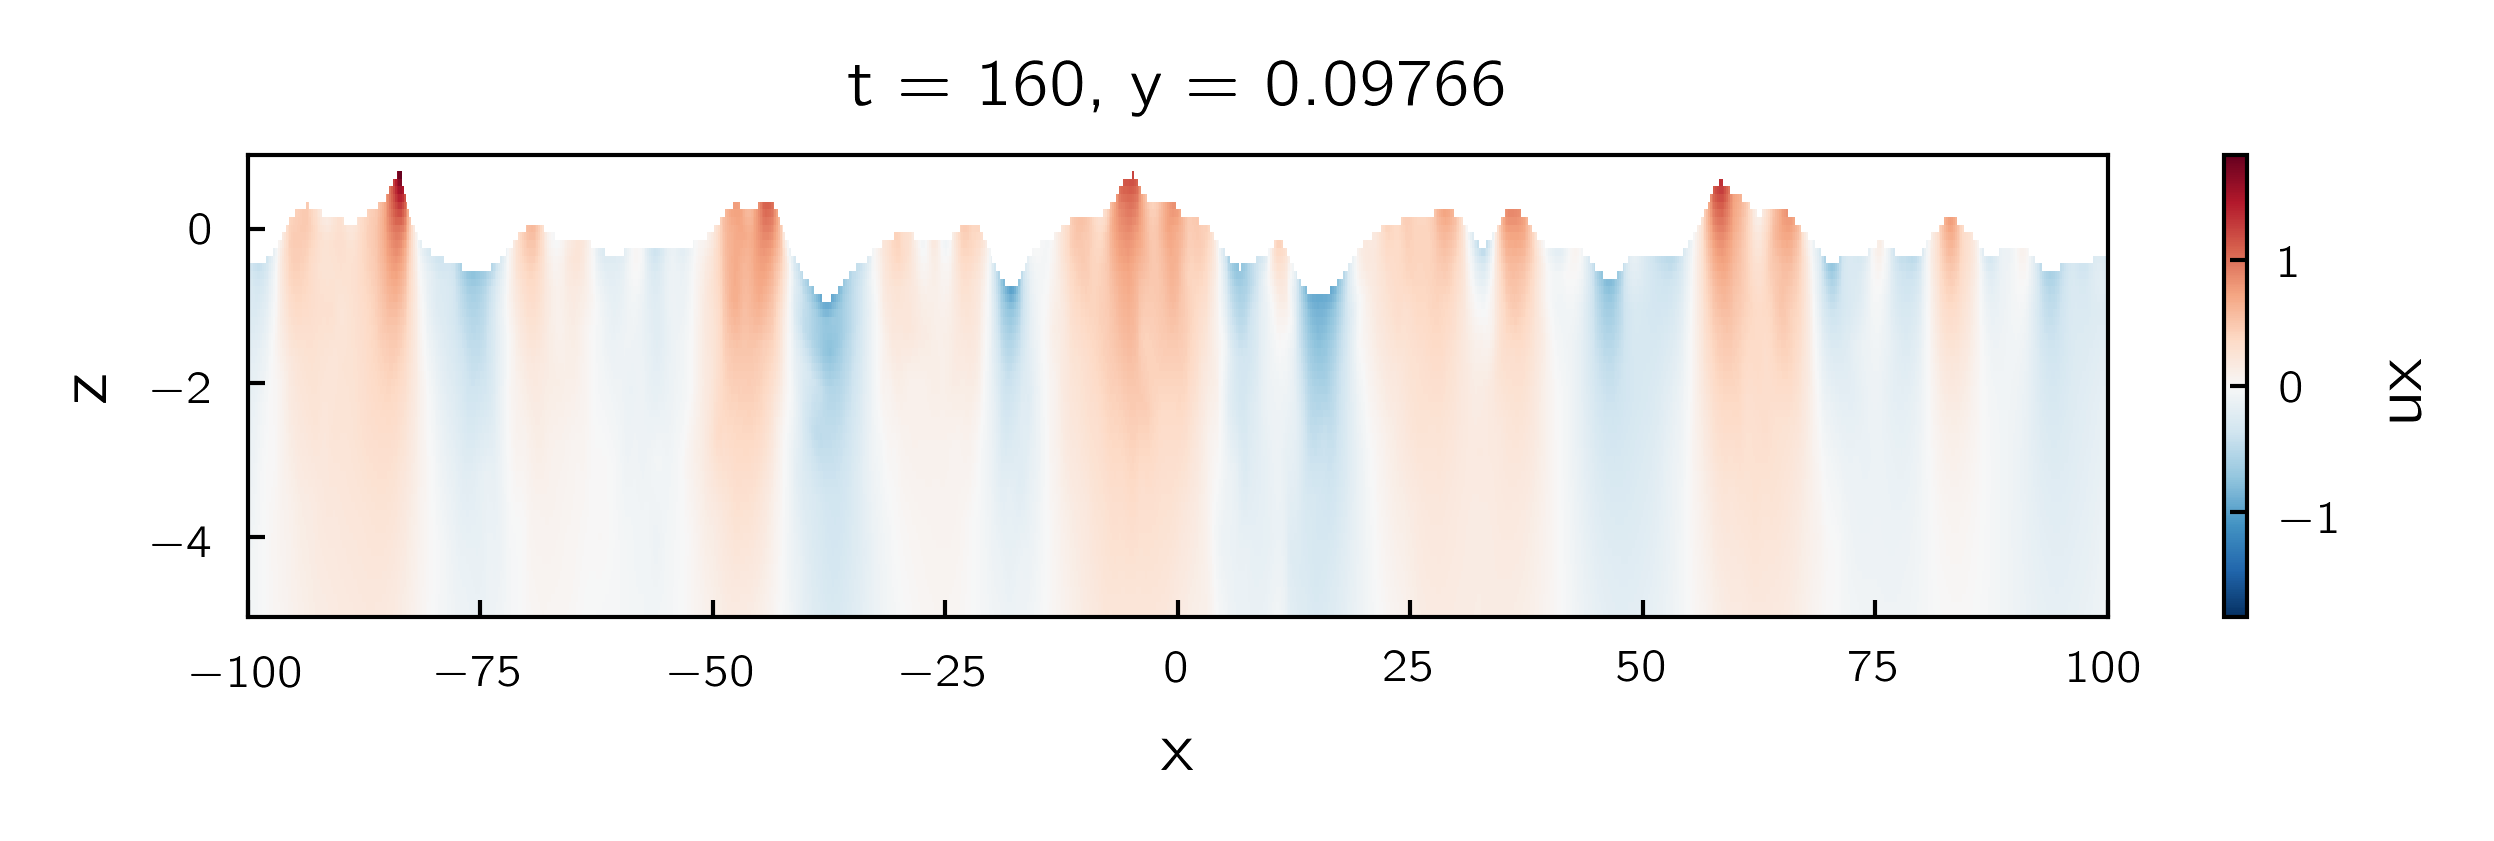

In [16]:
fig = plt.figure(figsize=[5,1])
ds_interp = ds_interp.assign_coords(z=('zl', znew))
ds_interp.ux.isel(y=512).plot(x='x',y='z')

In [105]:
epsilon1_vort2

<xarray.DataArray (x: 1023, y: 1023, zl: 60)>
array([[[0.01984424, 0.01996689, 0.02009398, ...,        nan,
                nan,        nan],
        [0.01905068, 0.01940375, 0.01976046, ...,        nan,
                nan,        nan],
        [0.02007682, 0.02041881, 0.02076573, ...,        nan,
                nan,        nan],
        ...,
        [0.0185604 , 0.01804011, 0.01752763, ...,        nan,
                nan,        nan],
        [0.01864176, 0.01839626, 0.0181563 , ...,        nan,
                nan,        nan],
        [0.01814018, 0.01806324, 0.01799543, ...,        nan,
                nan,        nan]],

       [[0.01639032, 0.01639501, 0.01640176, ...,        nan,
                nan,        nan],
        [0.01847894, 0.0188037 , 0.01913465, ...,        nan,
                nan,        nan],
        [0.01826854, 0.01850782, 0.01875411, ...,        nan,
                nan,        nan],
...
        [0.02927331, 0.02895393, 0.02863683, ...,        nan,
                nan,        nan],
        [0.0345722 , 0.03433147, 0.03409178, ...,        nan,
                nan,        nan],
        [0.03686414, 0.03673309, 0.03660406, ...,        nan,
                nan,        nan]],

       [[0.02839069, 0.02890559, 0.02945868, ...,        nan,
                nan,        nan],
        [0.02270848, 0.02325335, 0.02382653, ...,        nan,
                nan,        nan],
        [0.01774505, 0.01808037, 0.01842225, ...,        nan,
                nan,        nan],
        ...,
        [0.02807995, 0.02770973, 0.02734242, ...,        nan,
                nan,        nan],
        [0.03178119, 0.03155575, 0.03133242, ...,        nan,
                nan,        nan],
        [0.03236413, 0.03226392, 0.03217294, ...,        nan,
                nan,        nan]]])
Coordinates:
  * x        (x) float64 -99.71 -99.51 -99.32 -99.12 ... 99.32 99.51 99.71 99.9
  * y        (y) float64 -99.71 -99.51 -99.32 -99.12 ... 99.32 99.51 99.71 99.9
    t        int64 160
    z        (zl) float64 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 ... 0.5 0.6 0.7 0.8 0.9
Dimensions without coordinates: zl

In [84]:
# In Cartesian grid - strain rate
with ProgressBar():
    epsilon1, epsilon1_vort2 = dissipation(ds_interp)
epsilon1 = epsilon1.compute().assign_coords(z=('zl', znew))
epsilon1_vort2 = epsilon1_vort2.compute().assign_coords(z=('zl', znew))

# In layered grid - strain rate
epsilon2, epsilon2_vort2 = dissipation_layer(ds.sel(t=160))
epsilon2 = epsilon2.compute().assign_coords(z=(['zl','x','y'], ds.z.sel(t=160).values[:,:-1,:-1]))
epsilon2_vort2 = epsilon2_vort2.compute().assign_coords(z=(['zl','x','y'], ds.z.sel(t=160).values[:,:-1,:-1]))

# In Cartesian grid - vorticity 
epsilon3 = ds_interp.omegax**2 + ds_interp.omegay**2 + ds_interp.omegaz**2

# In layered grid - vorticity
epsilon4 = ds.sel(t=160).omegax**2 + ds.sel(t=160).omegay**2 + ds.sel(t=160).omegaz**2

/Users/jiarongw/miniconda3/envs/gp-tigressdata/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, '')

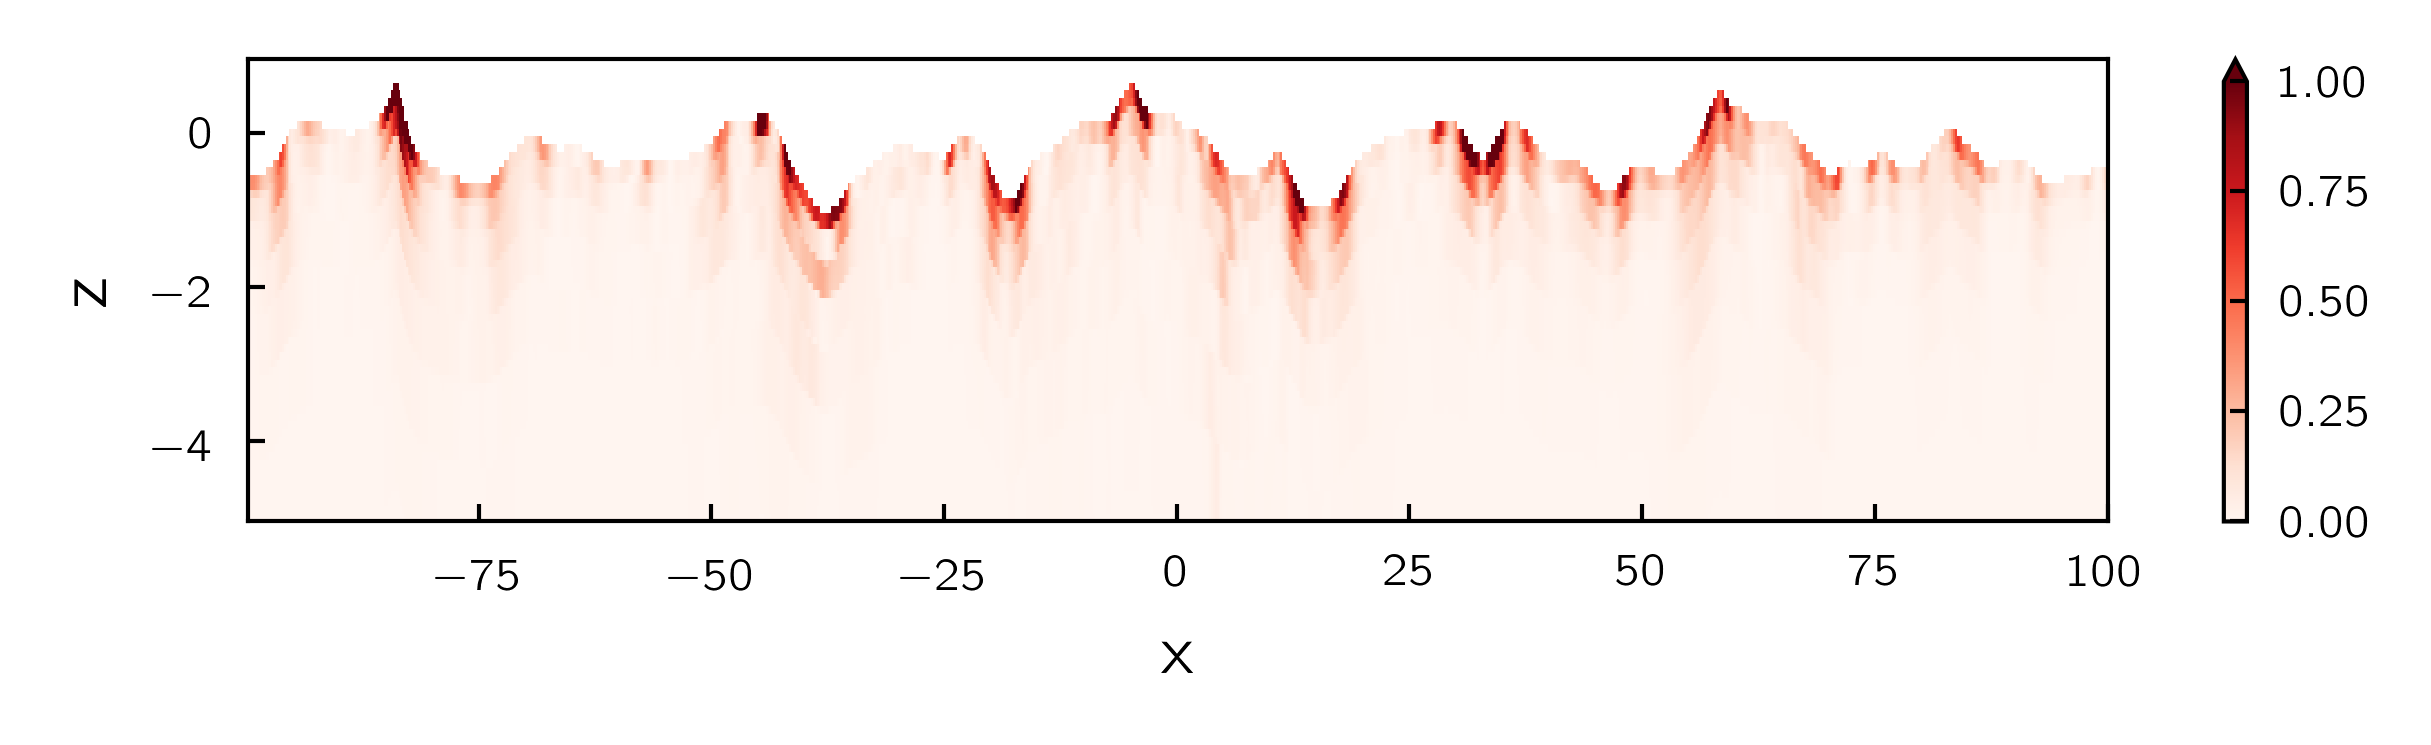

In [71]:
fig = plt.figure(figsize=[5,1])
epsilon1.isel(y=512).plot(x='x', y='z', vmax=1, vmin=0, cmap='Reds')
plt.title('')

Text(0.5, 1.0, '')

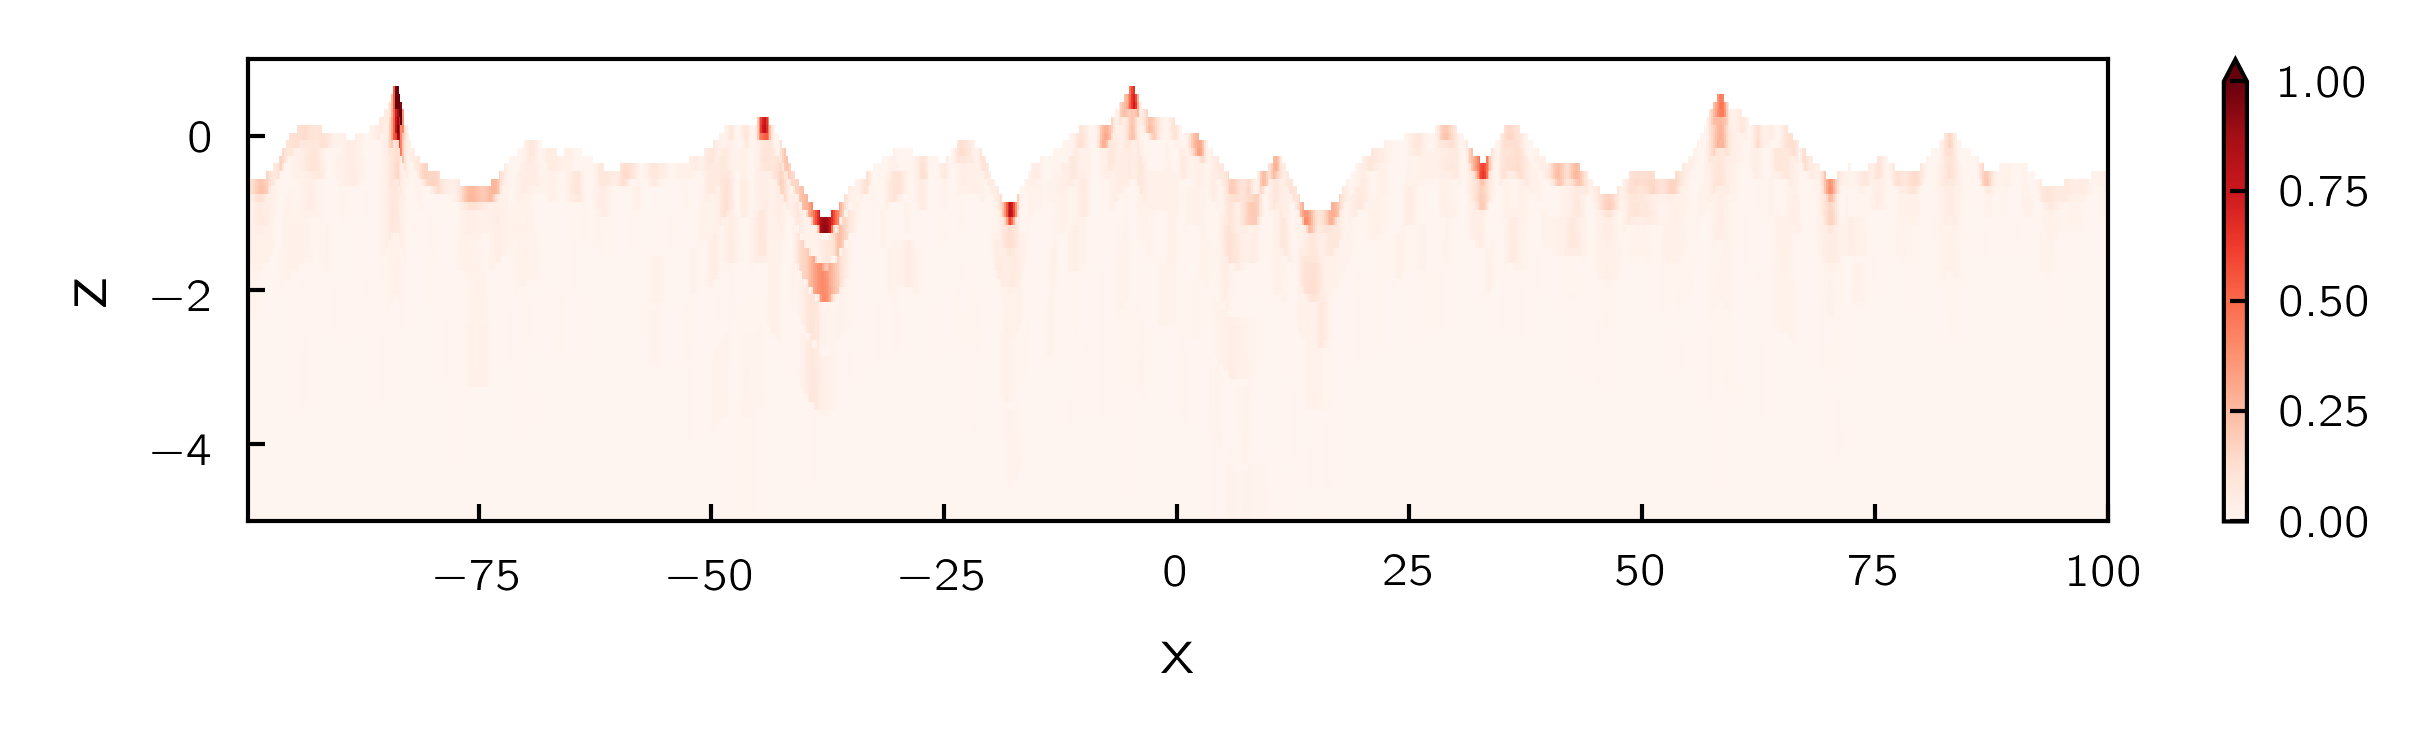

In [88]:
fig = plt.figure(figsize=[5,1]); 
epsilon1_vort2.isel(y=512).plot(x='x', y='z', vmax=1, vmin=0, cmap='Reds')
plt.ylim([-5,1])
plt.title('')

/Users/jiarongw/miniconda3/envs/gp-tigressdata/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, '')

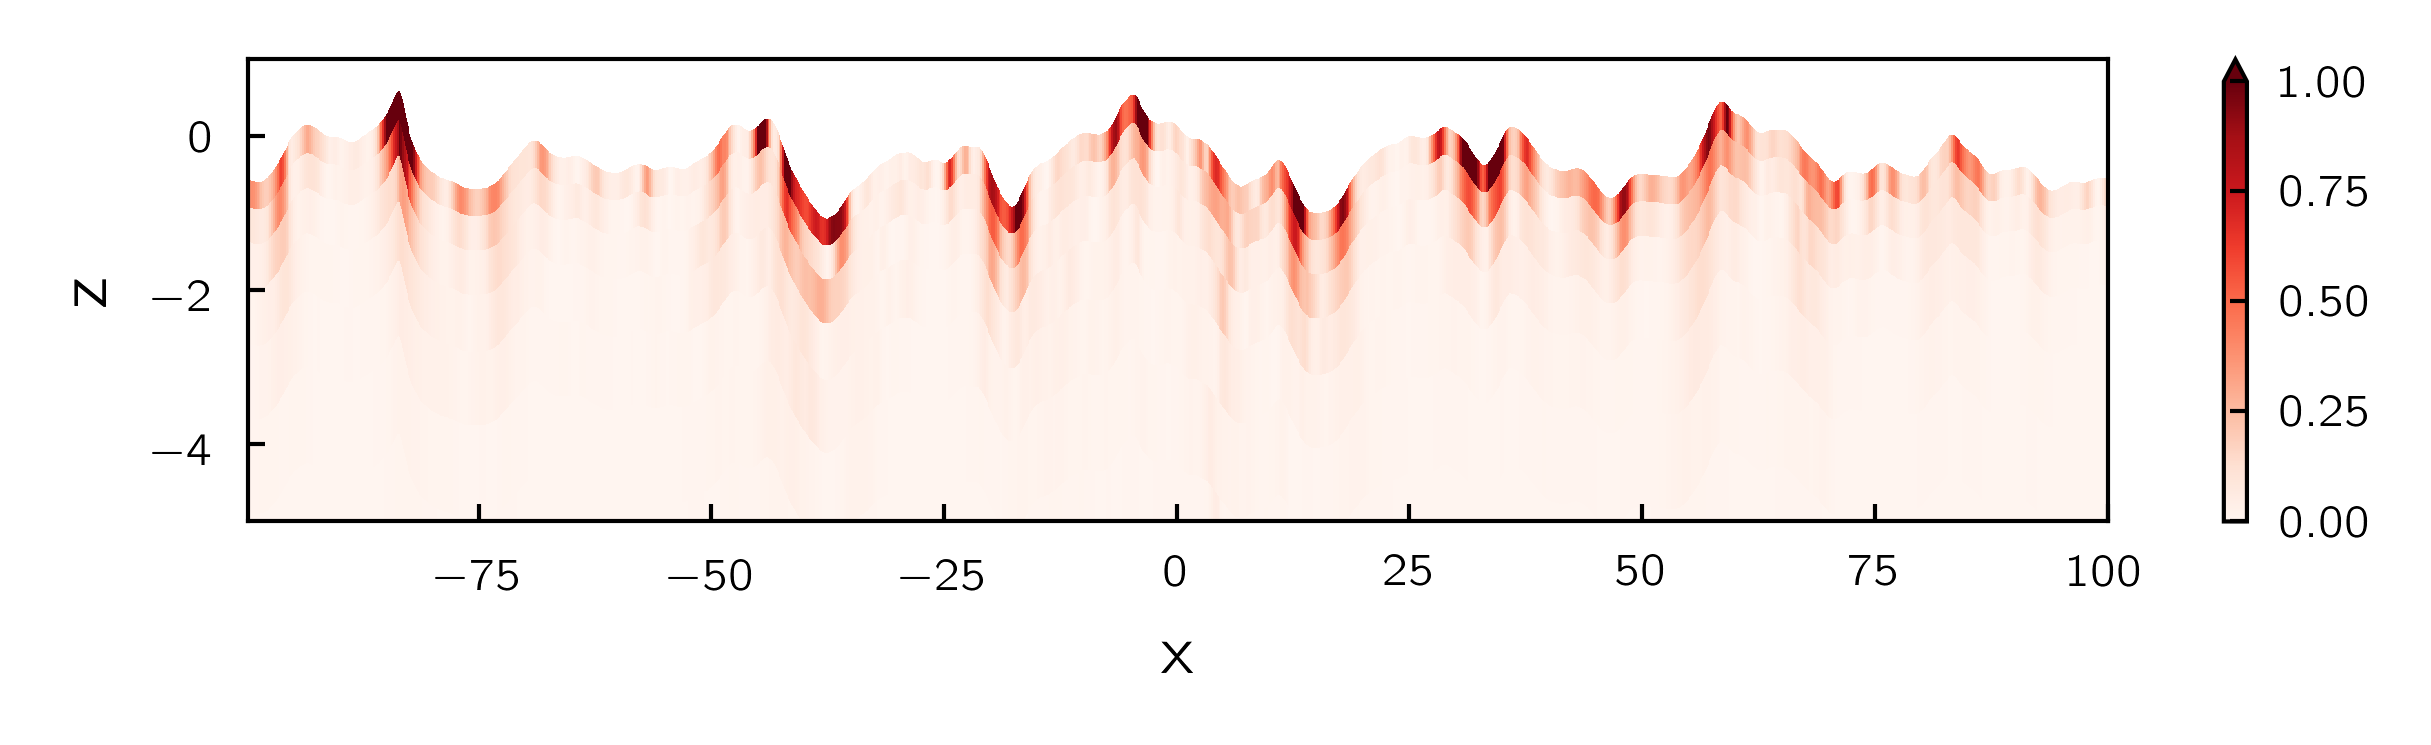

In [72]:
fig = plt.figure(figsize=[5,1]); 
epsilon2.isel(y=512).plot(x='x', y='z', vmax=1, vmin=0, cmap='Reds')
plt.ylim([-5,1])
plt.title('')

Text(0.5, 1.0, '')

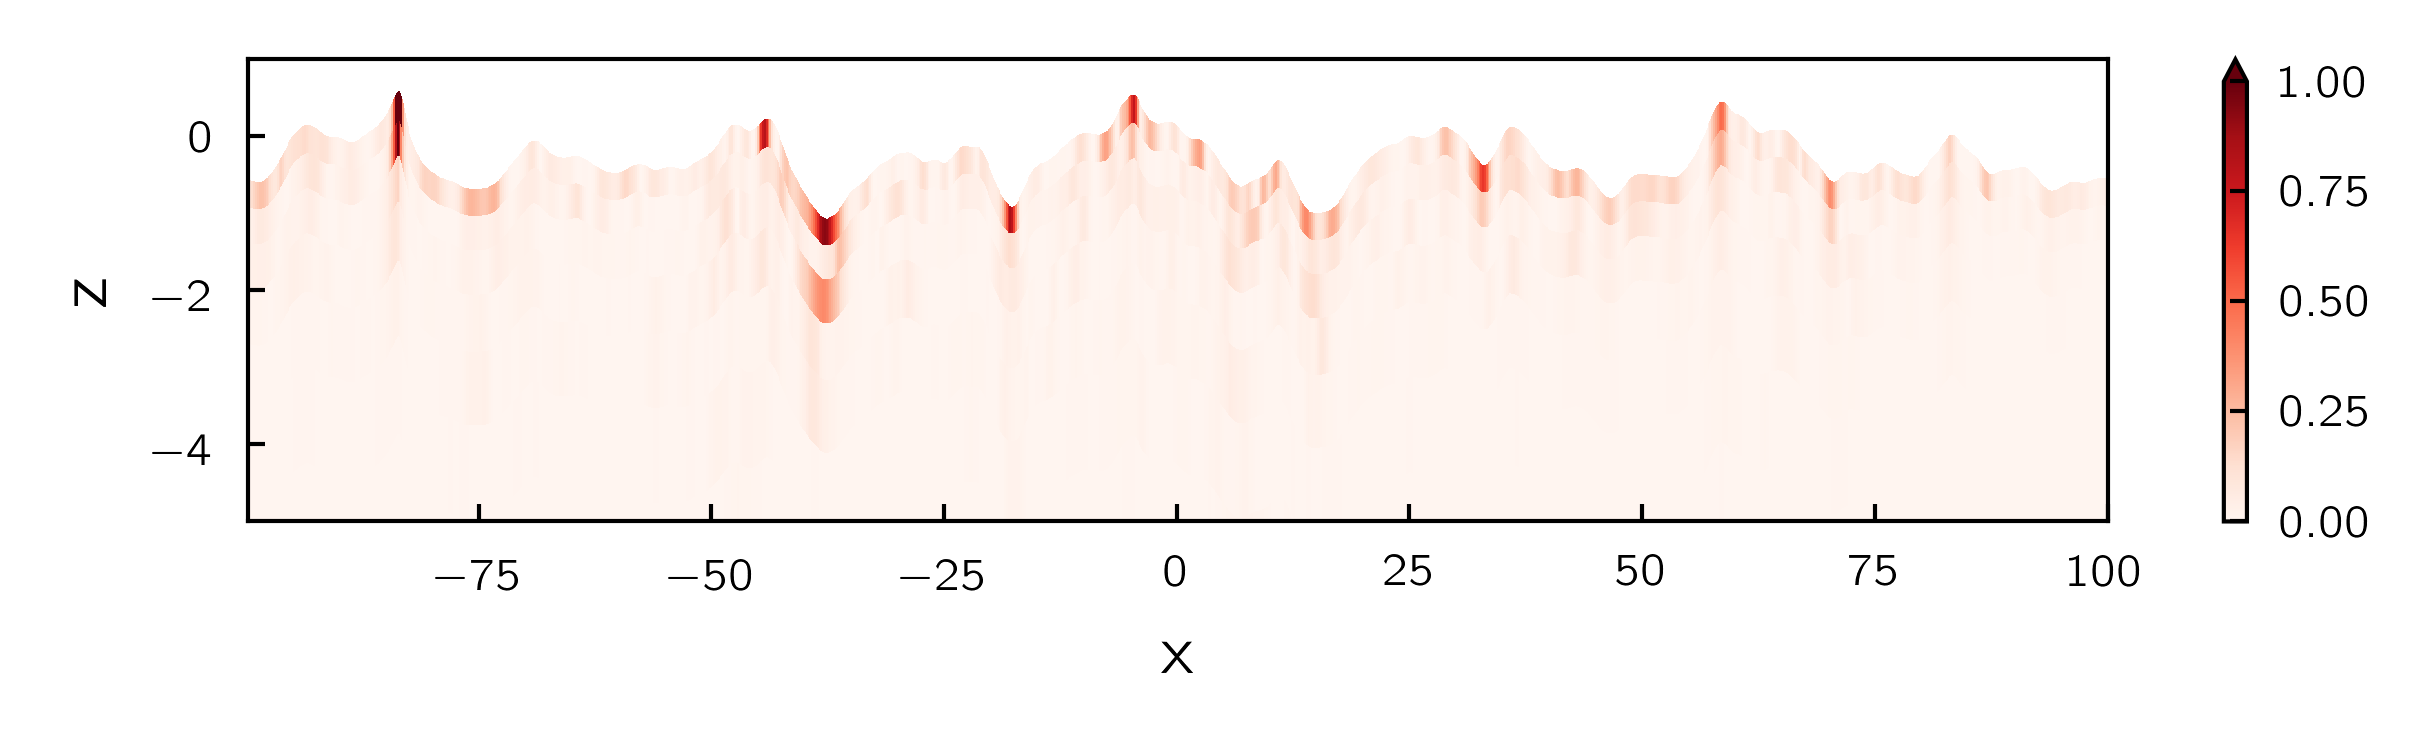

In [86]:
fig = plt.figure(figsize=[5,1]); 
epsilon2_vort2.isel(y=512).plot(x='x', y='z', vmax=1, vmin=0, cmap='Reds')
plt.ylim([-5,1])
plt.title('')

In [ ]:
fig = plt.figure(figsize=[5,1]); 
epsilon2_vort2.isel(y=512).plot(x='x', y='z', vmax=1, vmin=0, cmap='Reds')
plt.ylim([-5,1])
plt.title('')

Text(0.5, 1.0, '')

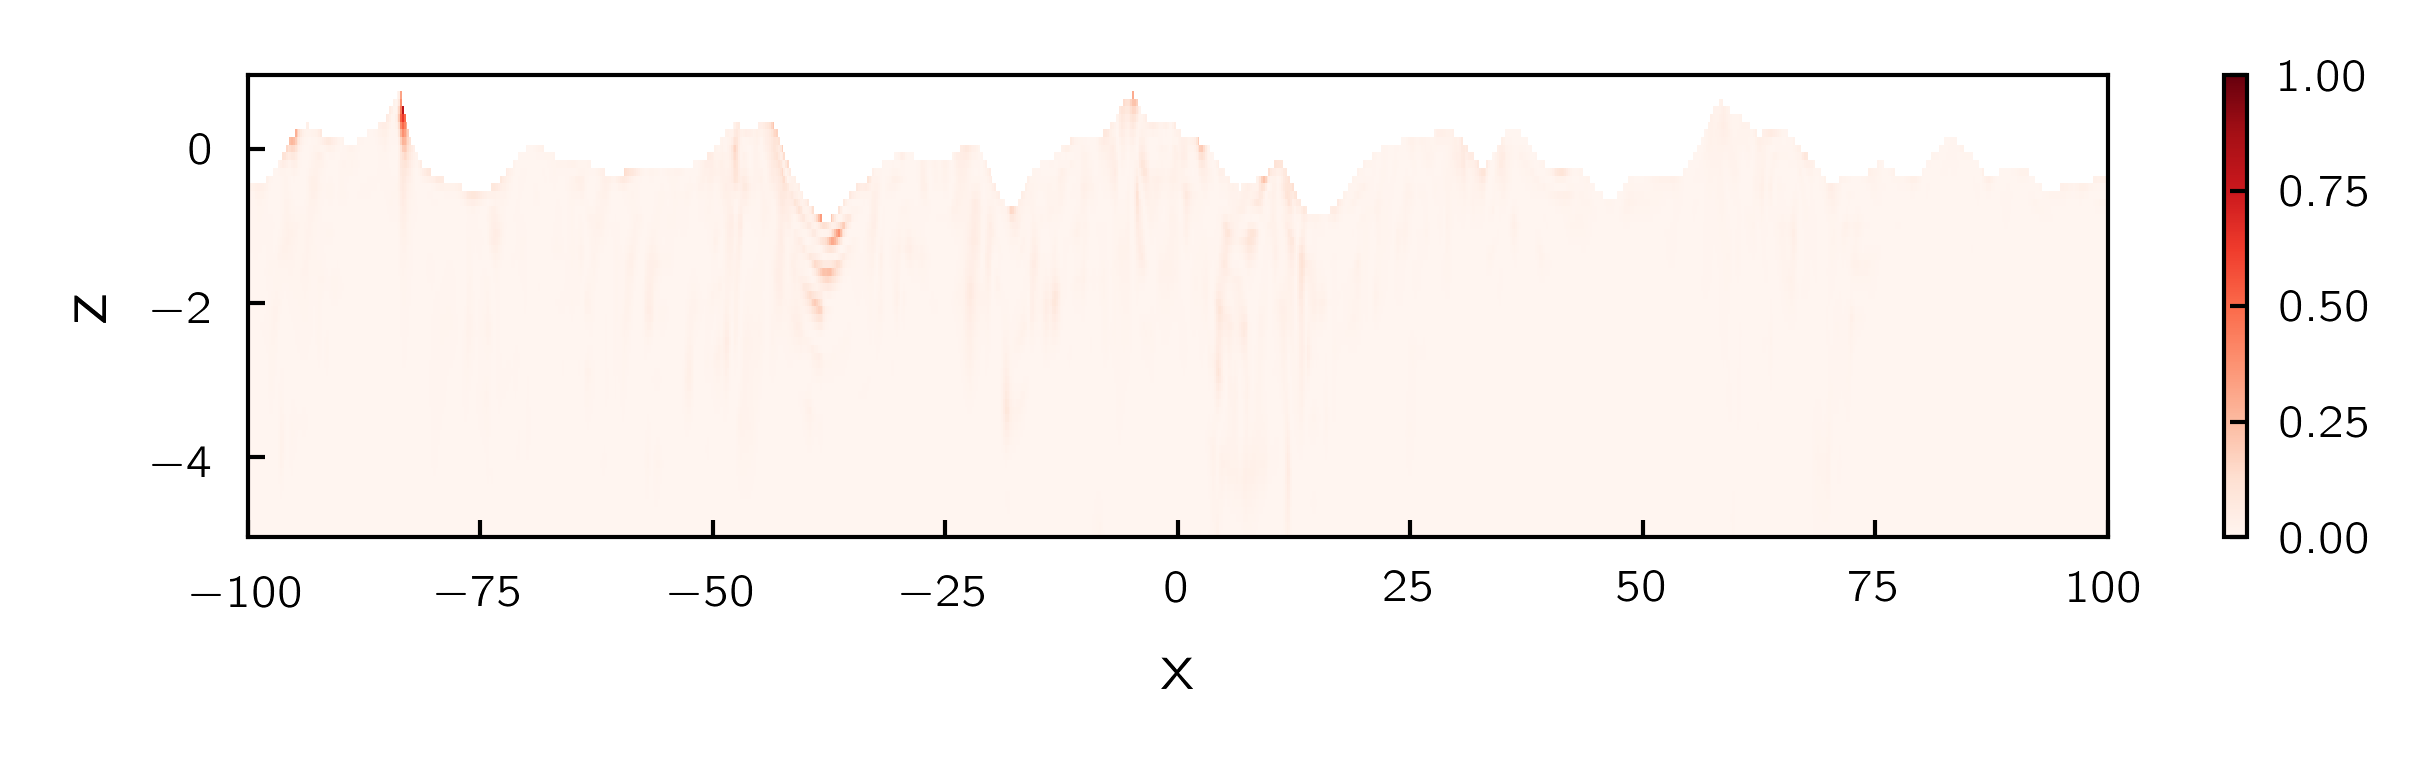

In [80]:
fig = plt.figure(figsize=[5,1])
epsilon3.isel(y=512).plot(x='x', y='z', vmax=1, vmin=0, cmap='Reds')
plt.title('')

Text(0.5, 1.0, '')

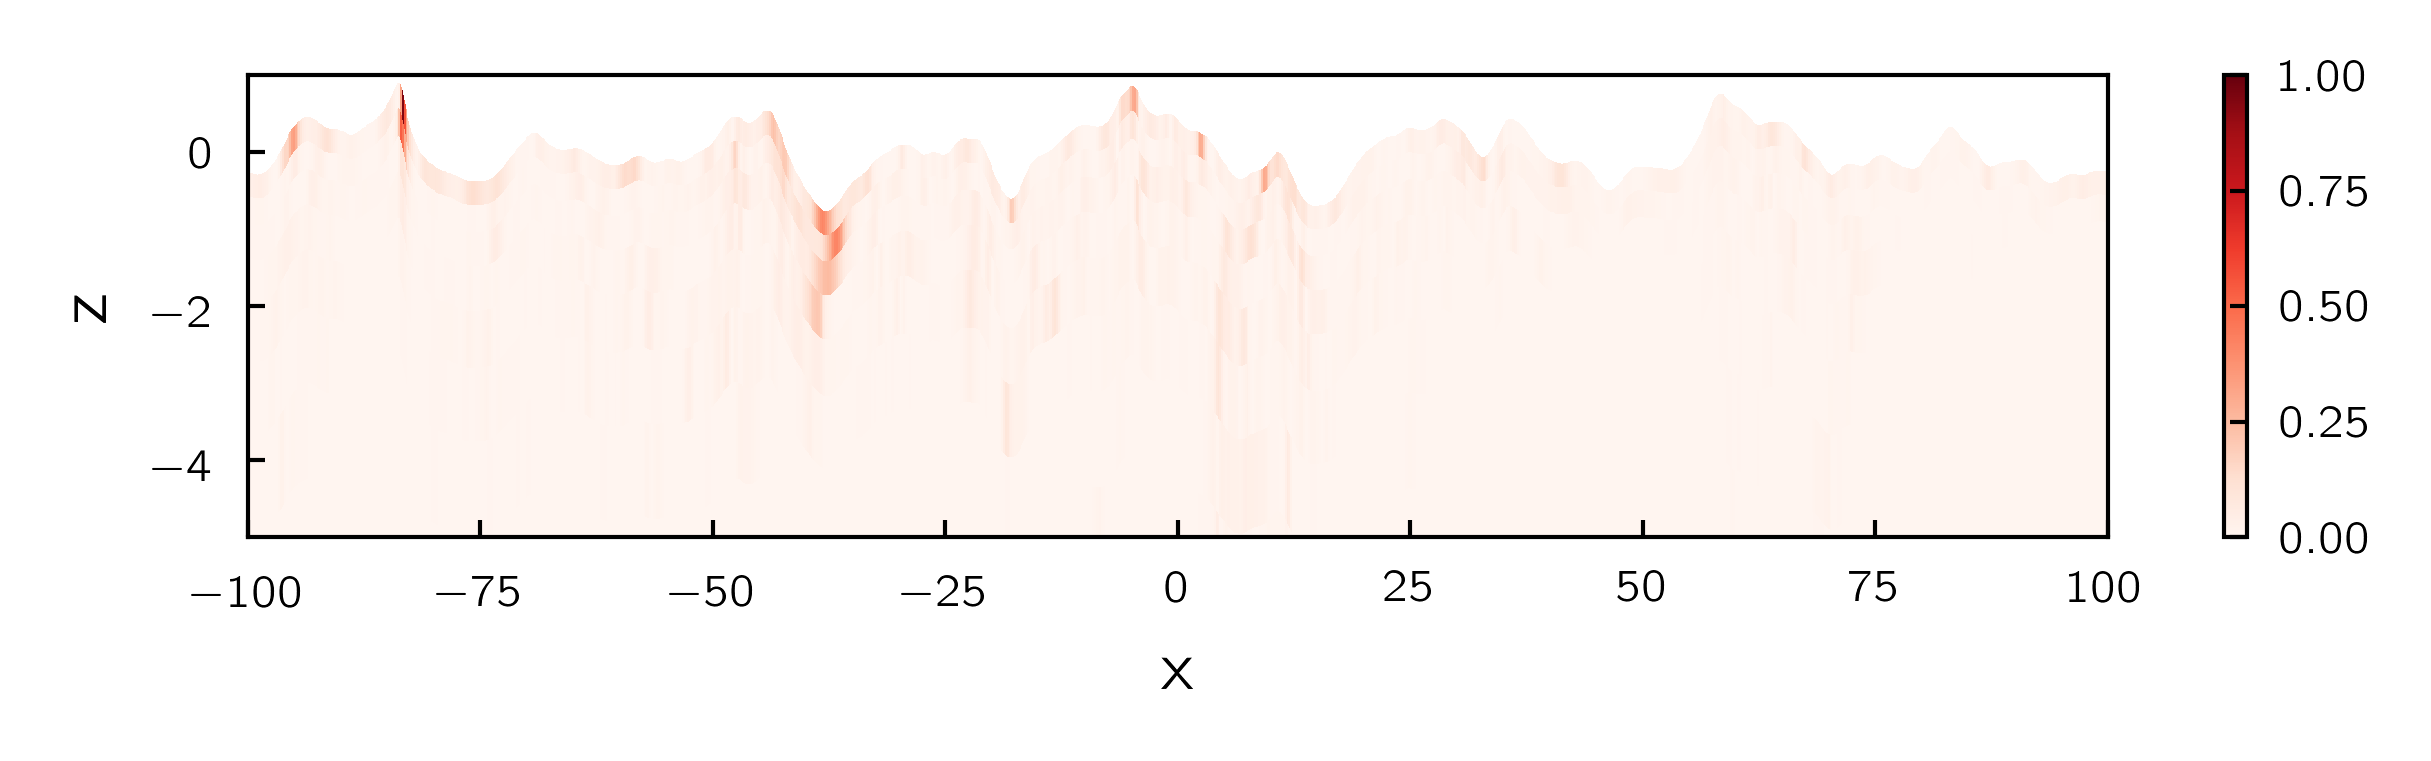

In [81]:
fig = plt.figure(figsize=[5,1])
epsilon4.isel(y=512).plot(x='x', y='z', vmax=1, vmin=0, cmap='Reds')
plt.ylim([-5,1])
plt.title('')

(0.0001, 0.5)

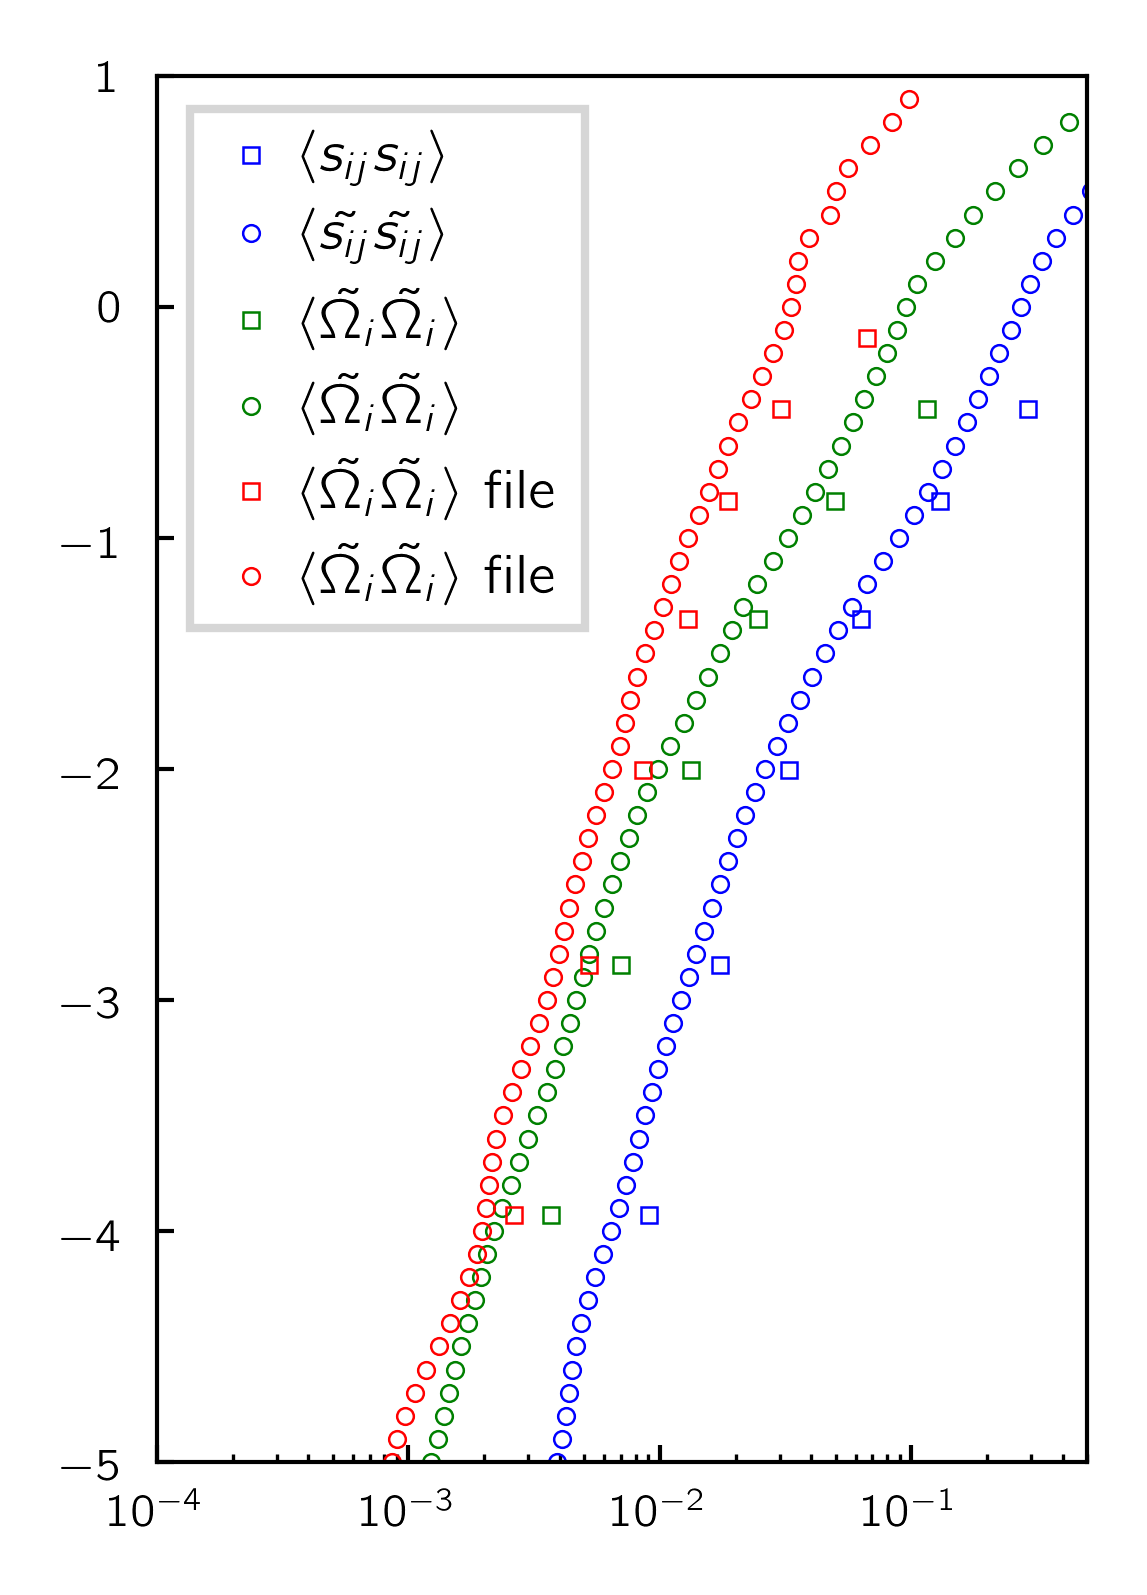

In [104]:
fig = plt.figure(figsize=[2,3])
plt.plot(epsilon2.mean(dim=['x','y']), epsilon2.z.mean(dim=['x','y']), 's', c='b', 
         label=r'$\langle s_{ij}s_{ij} \rangle$')
plt.plot(epsilon1.mean(dim=['x','y']), epsilon1.z, 'o', c='b', 
         label=r'$\langle \tilde{s_{ij}}\tilde{s_{ij}} \rangle$')

plt.plot(epsilon2_vort2.mean(dim=['x','y']), epsilon2.z.mean(dim=['x','y']), 's', c='g', 
         label=r'$\langle \tilde{\Omega_{i}}\tilde{\Omega_{i}} \rangle$')
plt.plot(epsilon1_vort2.mean(dim=['x','y']), epsilon1.z, 'o', c='g', 
         label=r'$\langle \tilde{\Omega_{i}}\tilde{\Omega_{i}} \rangle$')

plt.plot(epsilon4.mean(dim=['x','y']), epsilon4.z.mean(dim=['x','y']), 's', c='r', 
         label=r'$\langle \tilde{\Omega_{i}}\tilde{\Omega_{i}} \rangle$ file')
plt.plot(epsilon3.mean(dim=['x','y']), epsilon3.z, 'o', c='r', 
         label=r'$\langle \tilde{\Omega_{i}}\tilde{\Omega_{i}} \rangle$ file')

plt.legend()
plt.ylim([-5,1])
plt.xscale('log'); plt.xlim([0.0001, 0.5])

In [ ]:
epsilon1 = dissipation(ds_interp).compute()
epsilon1 = epsilon1.assign_coords(z=('zl', znew))

''' Using Omega'''
''' Interpolated individual components '''
epsilon2 = ds_interp.omegax**2 + ds_interp.omegay**2 + ds_interp.omegaz**2
epsilon2 = epsilon2.assign_coords(z=('zl', znew))

epsilon3 = ds.sel(t=120).omegax**2 + ds.sel(t=120).omegay**2 + ds.sel(t=120).omegaz**2

epsilon4 = interpz(znew, ds.z.sel(t=120), epsilon3).compute()
epsilon4 = epsilon4.assign_coords(z=('zl', znew))

In [ ]:
fig = plt.figure(figsize=[5,1])
# Cartesian coord
img = epsilon1.isel(y=100).plot(x='x', y='z', vmax=0.1, vmin=0, cmap='Reds')
img.axes.set_title('')

# Layered coord
img = epsilon3.isel(y=250).plot(x='x', y='z', vmax=0.1, vmin=0, cmap='Reds')
img.axes.set_title('')
plt.axhline(ds.z.isel(zl=-1).min().values, ls='--', c='gray')
plt.ylim([-20, 2])

In [ ]:
fig = plt.figure(figsize=[1.5,2])
plt.plot(epsilon1.mean(['x','y'])[:-1], epsilon1.z[:-1], 'o', 
         label=r'$2\langle\tilde{s_{ij}}\tilde{s_{ij}}\rangle$')
plt.plot(epsilon2.mean(['x','y'])[:-1], epsilon2.z[:-1], '^',
         label=r'$\langle\tilde{\Omega_i}\tilde{\Omega_i}\rangle$')
plt.ylim([-10,0])
plt.plot(epsilon3.mean(['x','y']), epsilon3.z.mean(['x','y']), 's',
         label=r'$\langle\Omega_i\Omega_i\rangle$')
plt.ylim([-10,0]); plt.ylabel('$z$ (m)')
plt.xlim([0.0001,0.05]); 
# plt.xscale('log')
plt.axhline(ds.z.isel(zl=-1).min().values, ls='--', c='gray')

plt.legend()
